In [299]:
import numpy as np
import pandas as pd
import csv
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import requests
from bs4 import BeautifulSoup
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\marlo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1. Load National Research Council

In [244]:
file_path = "NRC-Emotion-Lexicon/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc_lexicon = {}
with open(file_path, newline='') as csvfile:
    text = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in text:
        if int(row[2]) == 1:
            if row[0] not in nrc_lexicon.keys():
                nrc_lexicon[row[0]] = []
            nrc_lexicon[row[0]].append(row[1])

In [245]:
# Vista primors 5 elementos del diccionario
print(len(nrc_lexicon.keys()))
for k,v in list(nrc_lexicon.items())[:5]:
    print(k, v)

6453
abacus ['trust']
abandon ['fear', 'negative', 'sadness']
abandoned ['anger', 'fear', 'negative', 'sadness']
abandonment ['anger', 'fear', 'negative', 'sadness', 'surprise']
abba ['positive']


### 2. Extender el léxico NRC utilizando WordNet

In [246]:
wordnet_to_penn = {
 'n': 'NN', # sustantivo
 'v': 'VB', # verbo
 'a': 'JJ', # adjetivo
 's': 'JJ', # adjetivo superlativo
 'r': 'RB', # adverbio
 'c': 'CC' # conjunción
}

penn_to_wordnet = {
 'CC': 'c', # Coordinating conjunction
 'CD': 'c', # Cardinal number
 'DT': 'c', # Determiner
 'EX': 'c', # Existential there
 'FW': 'x', # Foreign word
 'IN': 'c', # Preposition or subordinating conjunction
 'JJ': 'a', # Adjective
 'JJR': 'a', # Adjective, comparative
 'JJS': 'a', # Adjective, superlative
 'LS': 'c', # List item marker
 'MD': 'v', # Modal
 'NN': 'n', # Noun, singular or mass
 'NNS': 'n', # Noun, plural
 'NNP': 'n', # Proper noun, singular
 'NNPS': 'n', # Proper noun, plural
  'PDT': 'c', # Predeterminer
 'POS': 'c', # Possessive ending
 'PRP': 'n', # Personal pronoun
 'PRP$': 'n', # Possessive pronoun
 'RB': 'r', # Adverb
 'RBR': 'r', # Adverb, comparative
 'RBS': 'r', # Adverb, superlative
 'RP': 'r', # Particle
 'SYM': 'x', # Symbol
 'TO': 'c', # to
 'UH': 'x', # Interjection
 'VB': 'v', # Verb, base form
 'VBD': 'v', # Verb, past tense
 'VBG': 'v', # Verb, gerund or present participle
 'VBN': 'v', # Verb, past participle
 'VBP': 'v', # Verb, non-3rd person singular present
 'VBZ': 'v', # Verb, 3rd person singular present
 'WDT': 'c', # Wh-determiner
 'WP': 'n', # Wh-pronoun
 'WP$': 'n', # Possessive wh-pronoun
 'WRB': 'r', # Wh-adverb
 'X': 'x' # Any word not categorized by the other tags
 }

In [247]:
def getLemmaPos(word):
    lemmatizer = WordNetLemmatizer()
    pos_tag = wn.synsets(word)[0].pos()
    lemma = lemmatizer.lemmatize(word, pos=pos_tag)
    return lemma, pos_tag

In [248]:
def getSynonyms(word):
    synonyms = wn.synonyms(word)
    synonyms = [sub_array[0] for sub_array in synonyms if sub_array]
    sims = []
    for s in synonyms:
        for s1 in wn.synsets(s):
            [sims.append(str(lem.name())) for lem in s1.lemmas()]
    return list(set([getLemmaPos(word) for word in set(sims)]))

getSynonyms('joy')

[('ravish', 'v'),
 ('delectation', 'n'),
 ('gladden', 'v'),
 ('enjoy', 'v'),
 ('exuberate', 'v'),
 ('triumph', 'n'),
 ('joyfulness', 'n'),
 ('transport', 'n'),
 ('jubilate', 'v'),
 ('wallow', 'n'),
 ('revel', 'n'),
 ('exult', 'v'),
 ('pleasure', 'n'),
 ('enthrall', 'v'),
 ('enthral', 'v'),
 ('please', 'v'),
 ('enrapture', 'v'),
 ('rejoice', 'v'),
 ('joy', 'n'),
 ('joyousness', 'n'),
 ('enchant', 'v'),
 ('delight', 'n')]

In [249]:
def getHypernyms(word):
    synsets = wn.synsets(word)
    hypernyms = []
    for synset in synsets:
        for hypernym in synset.hypernyms():
            hypernyms.append((hypernym.name().split('.')[0], hypernym.pos()))
    return list(set(hypernyms))

getHypernyms('joy')

[('positive_stimulus', 'n'), ('feel', 'v'), ('emotion', 'n')]

In [250]:
def getHyponyms(word):
    synsets = wn.synsets(word)
    hyponyms = []
    for synset in synsets:
        for hyponym in synset.hyponyms():
            hyponyms.append((hyponym.name().split('.')[0], hyponym.pos()))
    return list(set(hyponyms))

getHyponyms('joy')

[('exult', 'v'),
 ('elation', 'n'),
 ('gladden', 'v'),
 ('overjoy', 'v'),
 ('exultation', 'n'),
 ('exuberance', 'n'),
 ('exhilaration', 'n'),
 ('cheer', 'v')]

In [251]:
def getDerivedWords(word):
    synsets = wn.synsets(word)
    derived_words = []
    for synset in synsets:
        derived_words.append((word, synset.pos()))
        for lemma in synset.lemmas():
            for related_lemma in lemma.derivationally_related_forms():
                derived_words.append((related_lemma.name(), synset.pos()))

    return list(set(derived_words))
getDerivedWords('joy')


[('please', 'n'),
 ('joy', 'v'),
 ('rejoicing', 'v'),
 ('joyous', 'n'),
 ('joyful', 'n'),
 ('delight', 'n'),
 ('joy', 'n')]

In [252]:
extended_lexicon = {}

for word in list(nrc_lexicon.keys()):
    emotions = nrc_lexicon[word]
    for symnonym in getSynonyms(word):
        if symnonym not in extended_lexicon.keys():
            extended_lexicon[symnonym] = emotions
    for hypernym in getHypernyms(word):
        if hypernym not in extended_lexicon.keys():
            extended_lexicon[hypernym] = emotions

    for hyponym in getHyponyms(word):
        if hyponym not in extended_lexicon.keys():
            extended_lexicon[hyponym] = emotions

    for derived_words in getDerivedWords(word):
        if derived_words not in extended_lexicon.keys():
            extended_lexicon[derived_words] = emotions

extended_lexicon

{('tablet', 'n'): ['trust'],
 ('calculator', 'n'): ['trust'],
 ('abacus', 'n'): ['trust'],
 ('vehemence', 'n'): ['fear', 'negative', 'sadness'],
 ('vacate', 'v'): ['fear', 'negative', 'sadness'],
 ('cede', 'v'): ['fear', 'negative', 'sadness'],
 ('forsake', 'v'): ['fear', 'negative', 'sadness'],
 ('empty', 'n'): ['fear', 'negative', 'sadness'],
 ('void', 'n'): ['fear', 'negative', 'sadness'],
 ('unconstraint', 'n'): ['fear', 'negative', 'sadness'],
 ('allow', 'v'): ['fear', 'negative', 'sadness'],
 ('fierceness', 'n'): ['fear', 'negative', 'sadness'],
 ('stop', 'n'): ['fear', 'negative', 'sadness'],
 ('part_with', 'v'): ['fear', 'negative', 'sadness'],
 ('throw_in_the_towel', 'v'): ['fear', 'negative', 'sadness'],
 ('lay_off', 'v'): ['fear', 'negative', 'sadness'],
 ('throw_in', 'v'): ['fear', 'negative', 'sadness'],
 ('furiousness', 'n'): ['fear', 'negative', 'sadness'],
 ('hollow', 'n'): ['fear', 'negative', 'sadness'],
 ('cease', 'n'): ['fear', 'negative', 'sadness'],
 ('surrender',

### 3. Cargar el texto de novelas clásicas disponibles en Project Gutenberg

In [253]:
books = {
 'Moby Dick': 'http://www.gutenberg.org/files/2554/2554-0.txt',
 'War and Peace': 'http://www.gutenberg.org/files/2600/2600-0.txt',
 'Pride and Prejudice': 'http://www.gutenberg.org/files/1342/1342-0.txt',
 'Crime and Punishment': 'http://www.gutenberg.org/files/2556/2556-0.txt',
 'The Adventures of Sherlock Holmes': 'http://www.gutenberg.org/files/1661/1661-0.txt',
 'Ulysses': 'http://www.gutenberg.org/files/4300/4300-0.txt',
 'The Odyssey': 'http://www.gutenberg.org/files/16133/16133-0.txt',
 'The Divine Comedy': 'http://www.gutenberg.org/files/15/15-0.txt',
 'Fortunata y Jacinta': 'https://www.gutenberg.org/files/1342/1342-h/1342-h.htm',
 'Critias': 'https://www.gutenberg.org/files/1571/1571-h/1571-h.htm'
}

In [254]:
def download_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text().lower()
    return text

In [255]:
downloaded_books = {}
for book in books:
    downloaded_books[book] = download_text(books[book])

### 4. Implementar una función para analizar el texto y contar las ocurrencias de palabras vinculadas con emociones en el texto

In [256]:
stoplist = ["also", "could", "p", "pp", "th", "however", "one", "two", "many", "i", "de", "la", "me", "my", "myself", 
            "the", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", 
            "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", 
            "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", 
            "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", 
            "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", 
            "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", 
            "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", 
            "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", 
            "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", 
            "t", "can", "will", "just", "don", "should", "now"]

In [263]:
tokenized_tagget_books = {}
for book in downloaded_books:
    tokenized_tagget_books[book] = pos_tag([word for word in re.findall(r"[^\W\d_]+|\d+", downloaded_books[book]) if word not in stoplist])

In [287]:
tokenized_tagget_books

{'Moby Dick': [('ï', 'NN'),
  ('project', 'NN'),
  ('gutenberg', 'NN'),
  ('ebook', 'NN'),
  ('crime', 'NN'),
  ('punishment', 'NN'),
  ('fyodor', 'NN'),
  ('dostoevsky', 'NN'),
  ('ebook', 'NN'),
  ('use', 'NN'),
  ('anyone', 'NN'),
  ('anywhere', 'RB'),
  ('united', 'JJ'),
  ('states', 'NNS'),
  ('parts', 'NNS'),
  ('world', 'NN'),
  ('cost', 'NN'),
  ('almost', 'RB'),
  ('restrictions', 'NNS'),
  ('whatsoever', 'VBP'),
  ('may', 'MD'),
  ('copy', 'VB'),
  ('give', 'VB'),
  ('away', 'RP'),
  ('re', 'NN'),
  ('use', 'NN'),
  ('terms', 'NNS'),
  ('project', 'VBP'),
  ('gutenberg', 'JJ'),
  ('license', 'NN'),
  ('included', 'VBD'),
  ('ebook', 'JJ'),
  ('online', 'NN'),
  ('www', 'NN'),
  ('gutenberg', 'NN'),
  ('org', 'NN'),
  ('located', 'VBN'),
  ('united', 'JJ'),
  ('states', 'NNS'),
  ('check', 'VBP'),
  ('laws', 'NNS'),
  ('country', 'NN'),
  ('located', 'VBD'),
  ('using', 'VBG'),
  ('ebook', 'NN'),
  ('title', 'NN'),
  ('crime', 'NN'),
  ('punishment', 'NN'),
  ('author', 'NN'),

In [290]:
lemmatizer = WordNetLemmatizer()

for book in tokenized_tagget_books:
    new_words_tag = []
    for word, tag in tokenized_tagget_books[book]:
        if tag in list(penn_to_wordnet.keys())[:-1]:
            new_words_tag.append((word, penn_to_wordnet[tag]))
        else:
            new_words_tag.append((word, penn_to_wordnet['X']))

    tokenized_tagget_books[book] = new_words_tag

tokenized_tagget_books

{'Moby Dick': [('ï', 'n'),
  ('project', 'n'),
  ('gutenberg', 'n'),
  ('ebook', 'n'),
  ('crime', 'n'),
  ('punishment', 'n'),
  ('fyodor', 'n'),
  ('dostoevsky', 'n'),
  ('ebook', 'n'),
  ('use', 'n'),
  ('anyone', 'n'),
  ('anywhere', 'r'),
  ('united', 'a'),
  ('states', 'n'),
  ('parts', 'n'),
  ('world', 'n'),
  ('cost', 'n'),
  ('almost', 'r'),
  ('restrictions', 'n'),
  ('whatsoever', 'v'),
  ('may', 'v'),
  ('copy', 'v'),
  ('give', 'v'),
  ('away', 'r'),
  ('re', 'n'),
  ('use', 'n'),
  ('terms', 'n'),
  ('project', 'v'),
  ('gutenberg', 'a'),
  ('license', 'n'),
  ('included', 'v'),
  ('ebook', 'a'),
  ('online', 'n'),
  ('www', 'n'),
  ('gutenberg', 'n'),
  ('org', 'n'),
  ('located', 'v'),
  ('united', 'a'),
  ('states', 'n'),
  ('check', 'v'),
  ('laws', 'n'),
  ('country', 'n'),
  ('located', 'v'),
  ('using', 'v'),
  ('ebook', 'n'),
  ('title', 'n'),
  ('crime', 'n'),
  ('punishment', 'n'),
  ('author', 'n'),
  ('fyodor', 'n'),
  ('dostoevsky', 'n'),
  ('translator', 'n

In [292]:
books_emotions={}
for book in tokenized_tagget_books:
    books_emotions[book] = []
    for wordpos in tokenized_tagget_books[book]:
        if wordpos in extended_lexicon.keys():
            books_emotions[book]+=extended_lexicon[wordpos]

In [297]:
for book in books_emotions.keys():
    books_emotions[book] = Counter(books_emotions[book])

In [298]:
books_emotions

{'Moby Dick': Counter({'positive': 18037,
          'negative': 15983,
          'trust': 10636,
          'fear': 7733,
          'anticipation': 7682,
          'sadness': 6466,
          'anger': 5465,
          'joy': 5367,
          'disgust': 4692,
          'surprise': 3976}),
 'War and Peace': Counter({'positive': 54917,
          'negative': 36671,
          'trust': 32165,
          'anticipation': 20827,
          'fear': 19089,
          'joy': 16196,
          'sadness': 14351,
          'anger': 12241,
          'surprise': 10242,
          'disgust': 9926}),
 'Pride and Prejudice': Counter({'positive': 14076,
          'trust': 8268,
          'negative': 7466,
          'anticipation': 5747,
          'joy': 4657,
          'fear': 3565,
          'sadness': 3058,
          'surprise': 2862,
          'anger': 2411,
          'disgust': 2097}),
 'Crime and Punishment': Counter({'positive': 5320,
          'negative': 4057,
          'trust': 3145,
          'anticipatio

### 5. Presentar los resultados del análisis de sentimientos en las novelas clásicas.

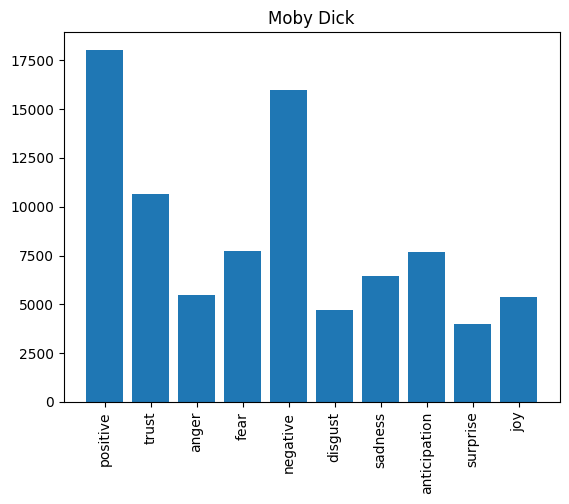

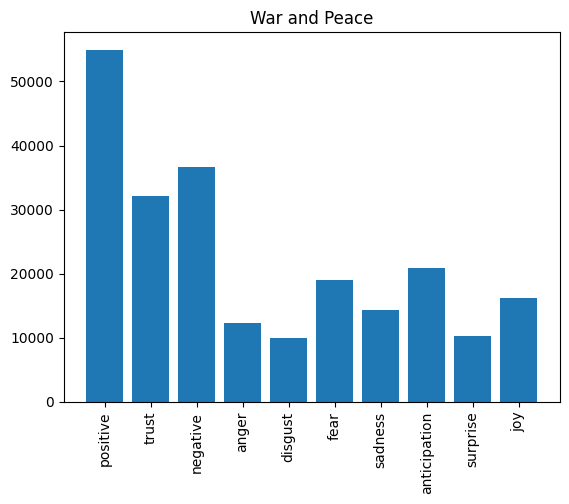

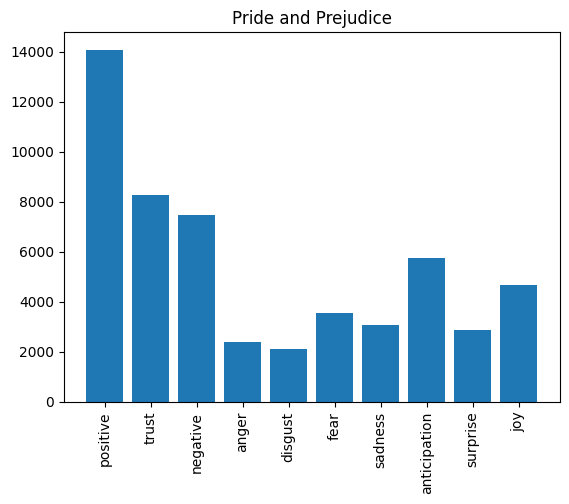

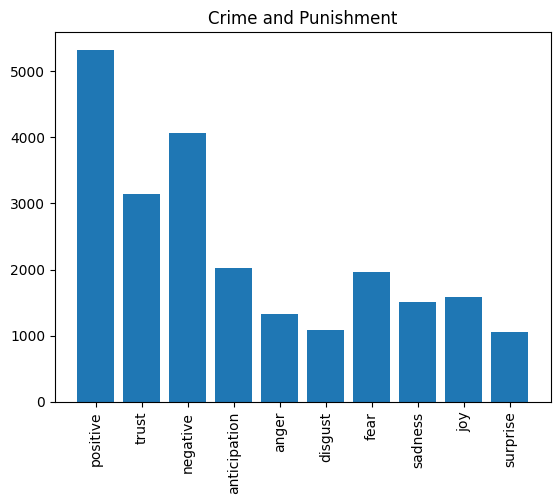

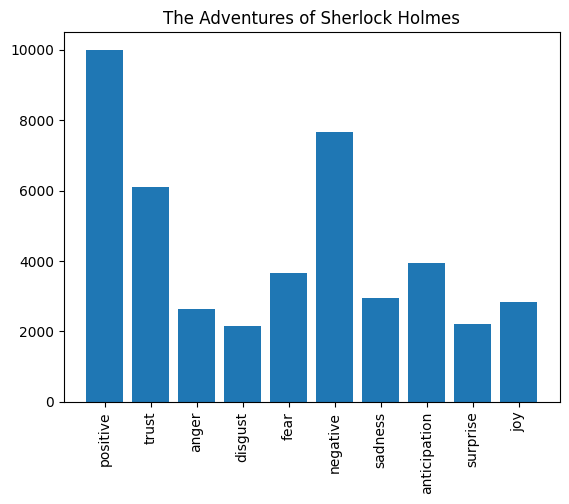

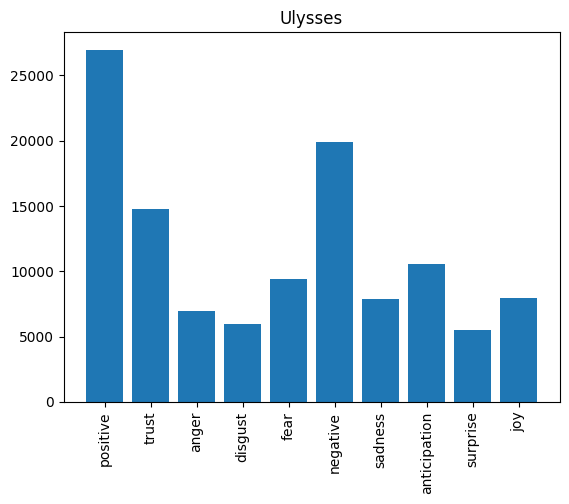

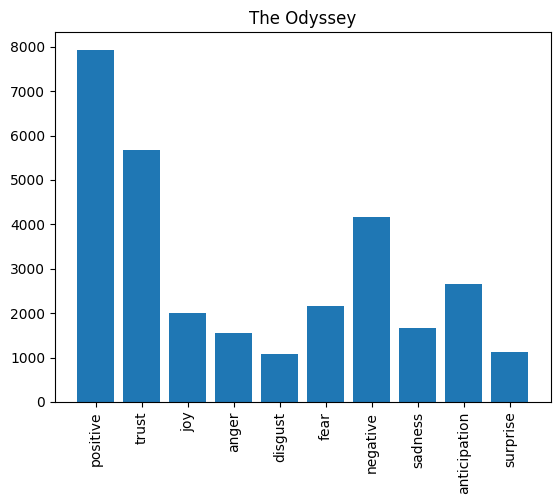

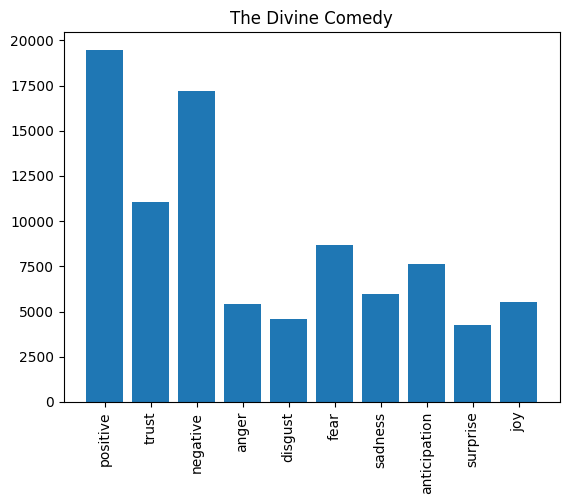

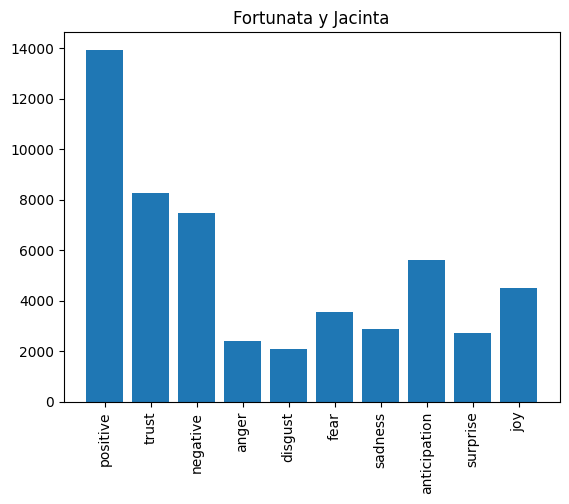

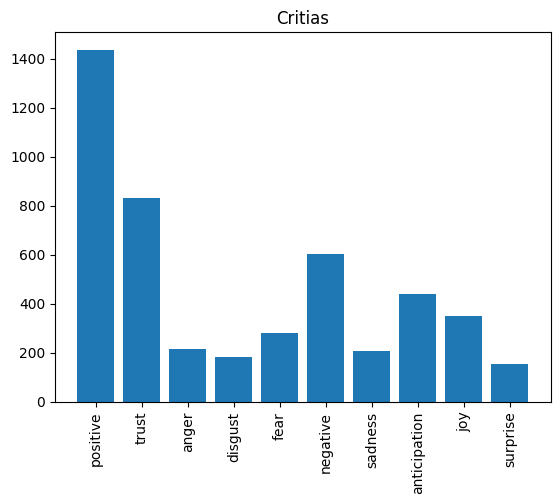

In [306]:
for book in books_emotions.keys():
    emotions = books_emotions[book].keys()
    freq = books_emotions[book].values()
    plt.bar(emotions, freq, label=emotions)
    plt.title(book)
    plt.xticks(rotation='vertical')
    plt.show()